In [2]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#está dando errado se tentar pegar as imagens do path images
files_path = [os.path.abspath(x) for x in os.listdir("./images/img400x_recorte_horizontal") if x.endswith('.png')]
print(files_path)

['/app/img400x_2.png', '/app/img400x_3.png', '/app/img400x_1.png']


img400x_2.png


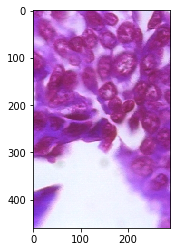

img400x_3.png


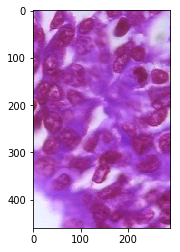

img400x_1.png


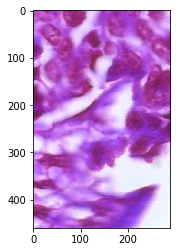

In [3]:
# diretorio, arquivo = path, filename = os.path.split(files_path[0])
# print(arquivo)
# img = cv2.imread(arquivo)
# plt.imshow(img)
# plt.show()
images = []
for i in files_path:
    diretorio, arquivo = path, filename = os.path.split(i)
    print(arquivo)
    img = cv2.imread(arquivo)
    images.append(img)
    plt.imshow(img)
    plt.show()
    


In [4]:
# Demora muito tempo para imagens menores que 400x
stitcher = cv2.createStitcher()
status, stitched = stitcher.stitch(images)
print(status)

0


# Algoritmo stitcher do opencv

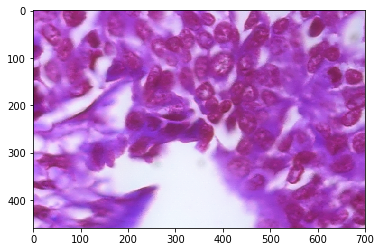

In [5]:
cv2.imwrite("output.png", stitched)
plt.imshow(stitched)
plt.show()

# ORB keypoints

In [16]:
# cv2.drawKeypoints está com erro em opencv 4.x, utilizar versão 3.4.5.20
a = []
kps1 = []
images = []

# disable OpenCL to because of bug in ORB in OpenCV 3.1
cv2.ocl.setUseOpenCL(False)

for i in files_path:
    diretorio, arquivo = path, filename = os.path.split(i)
    img = cv2.imread(arquivo)
    images.append(img)
    orb = cv2.ORB_create()
    

    
    keypoints, descriptors = orb.detectAndCompute(img, None)
    a.append(descriptors)
    kps1.append(keypoints)
    print(type(keypoints[0]))
#     img2 = cv2.drawKeypoints(img, keypoints, None, color=(0,255,0), flags=0)
    a.append(descriptors)
    kps1.append(keypoints)
#     a.append(descriptors)
#     img = cv2.drawKeypoints(img, keypoints, None)
#     print(type(descriptors))
    
#     plt.imshow(img2)
#     plt.show()



<class 'cv2.KeyPoint'>
<class 'cv2.KeyPoint'>
<class 'cv2.KeyPoint'>


imageF 0
imageF 1


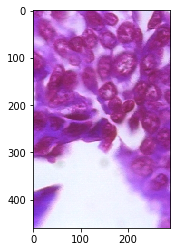

UnboundLocalError: local variable 'kp' referenced before assignment

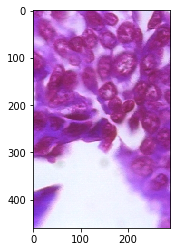

In [43]:
def stackImagesKeypointMatching(file_list):

    orb = cv2.ORB_create()

    # disable OpenCL to because of bug in ORB in OpenCV 3.1
    cv2.ocl.setUseOpenCL(False)
    

    stacked_image = None
    first_image = None
    first_kp = None
    first_des = None
    for image in file_list:
        
        print('imageF 0')
        plt.show()
        plt.imshow(image)
        
        imageF = image.astype(np.float32) / 255
        
        print('imageF 1')
        plt.show()
        plt.imshow(imageF)

        # compute the descriptors with ORB
        kp = orb.detect(image, None)
        kp, des = orb.compute(image, kp)

        # create BFMatcher object
        matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

        if first_image is None:
            print('hello')
            # Save keypoints for first image
            stacked_image = imageF
            first_image = image
            first_kp = kp
            first_des = des
        else:
             # Find matches and sort them in the order of their distance
            matches = matcher.match(first_des, des)
            matches = sorted(matches, key=lambda x: x.distance)

            src_pts = np.float32(
                [first_kp[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
            dst_pts = np.float32(
                [kp[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

            # Estimate perspective transformation
            M, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
            w, h, _ = imageF.shape
            
            print('imageF 2')
            plt.show()
            plt.imshow(imageF)
            
            imageF = cv2.warpPerspective(imageF, M, (h, w))
            
            print('imageF 3')
            plt.show()
            plt.imshow(imageF)
            
            stacked_image += imageF
            
            print('stacked...')
            plt.show()
            plt.imshow(stacked_image)

    stacked_image /= len(file_list)
    stacked_image = (stacked_image*255).astype(np.uint8)
    return stacked_image




stacked = stackImagesKeypointMatching([images[0],images[2]] )

print('final')

plt.show()
plt.imshow(stacked)


# img1 = cv2.imread("img1.png")
# img2 = cv2.imread("img2.png")

# stacked = stackImagesKeypointMatching([img1, img2])

# plt.show()
# plt.imshow(stacked)


# Homography

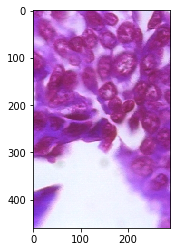

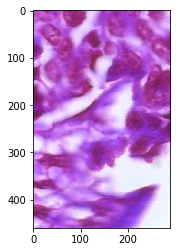

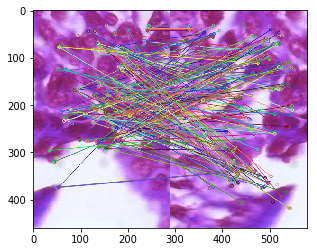

error: OpenCV(3.4.2) /io/opencv/modules/imgproc/src/imgwarp.cpp:2926: error: (-215:Assertion failed) (M0.type() == 5 || M0.type() == 6) && M0.rows == 3 && M0.cols == 3 in function 'warpPerspective'


In [51]:
img1 = images[0]
img2 = images[2]
id1 = 0
id2 = 2

# matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matches = matcher.match(a[id1], a[id2])

matches.sort(key = lambda x:x.distance, reverse=False)

# qtdGoodMatches = int(len(matches) * 0.15)
# matches = matches[:qtdGoodMatches]

plt.imshow(img1)
plt.show()

plt.imshow(img2)
plt.show()
    
imMatches = cv2.drawMatches(img1, kps1[id1], img2, kps1[id2], matches, None)
plt.imshow(imMatches)
plt.show()

points1 = np.zeros((len(matches), 2), dtype=np.float32)
points2 = np.zeros((len(matches), 2), dtype=np.float32)

for i, match in enumerate(matches):
    points1[1, :] = kps1[id1][match.queryIdx].pt
    points2[1, :] = kps1[id2][match.trainIdx].pt

h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)

height, width, channels = img2.shape
# print(h.size)
# if h.size != 0:
imgOutput = cv2.warpPerspective(img1, h, (width, height))

        
# images[1].shape


plt.imshow(imgOutput)
plt.show()

# print(type(mask))
#     print(type(match))
#     print(type(kps[0][match.queryIdx]))
#     points1 = kps1[match.queryIdx]

# bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)

# matches = bf.match(a[0],a[1])

# matches = sorted(matches, key = lambda x:x.distance)

# img3 = cv2.drawMatches(images[0],kps1[0],images[1],kps1[1], matches, None)
# plt.imshow(img3)
# plt.show()


OpenCV version: 3.4.2


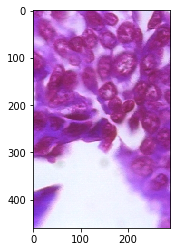

Creating Brute Forcer matcher


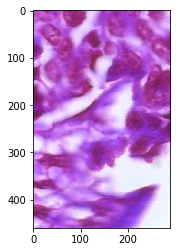

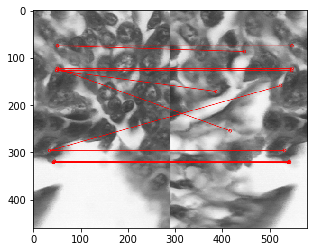

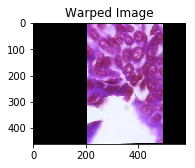

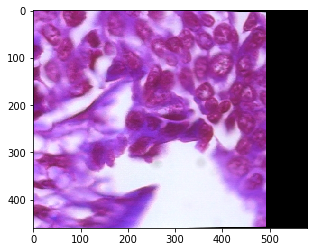

In [46]:
## ORB

print('OpenCV version: {}'.format(cv2.__version__) )


## Load images
queryImg = cv2.imread('img400x_2.png')
trainImg = cv2.imread('img400x_1.png')

plt.show()
plt.imshow(queryImg)

plt.show()
plt.imshow(trainImg)

## Convert to gray
grayQuery = cv2.cvtColor(queryImg, cv2.COLOR_BGR2GRAY)
grayTrain = cv2.cvtColor(trainImg, cv2.COLOR_BGR2GRAY)

## Creating orb detector
orb = cv2.ORB_create()
# orb = cv2.xfeatures2d.SIFT_create()


## Finding KPs and Descs
kpQuery, descQuery = orb.detectAndCompute(grayQuery, None)
kpTrain, descTrain = orb.detectAndCompute(grayTrain, None)

## Create Matcher
# matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
matcher = cv2.BFMatcher()
print('Creating Brute Forcer matcher')

## Matching
# matches = matcher.match(descQuery, descTrain)
matches = matcher.knnMatch(descQuery,descTrain, k=2)

# Apply ratio test
good = []
for m in matches:
    if m[0].distance < 0.5*m[1].distance:
        good.append(m)
matches = np.asarray(good)



if len(matches[:,0]) >= 4:
    src = np.float32([ kpQuery[m.queryIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    dst = np.float32([ kpTrain[m.trainIdx].pt for m in matches[:,0] ]).reshape(-1,1,2)
    H, masked = cv2.findHomography(src, dst, cv2.RANSAC, 5.0)
#print H
else:
    raise AssertionError('Can’t find enough keypoints.')
    
## Draw points
result = cv2.drawMatchesKnn(grayQuery, kpQuery, grayTrain, kpTrain, matches[:100], None, (255,0,0), flags=2)
plt.show()
plt.imshow(result)
plt.show()


## Stitching
dst = cv2.warpPerspective(queryImg,H,(trainImg.shape[1] + queryImg.shape[1], trainImg.shape[0]))
plt.subplot(122),plt.imshow(dst),plt.title('Warped Image')
plt.show()
plt.figure()

dst[0:trainImg.shape[0], 0:trainImg.shape[1]] = trainImg
cv2.imwrite('output.jpg',dst)
plt.imshow(dst)
plt.show()




# SURF

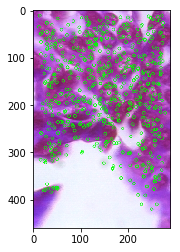

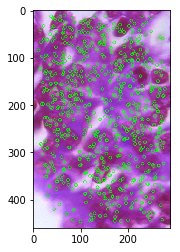

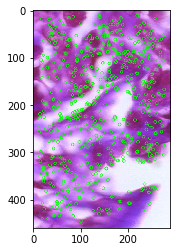

In [8]:
for i in images:
    surf = cv2.xfeatures2d.SURF_create()
    keypoints, descriptors = surf.detectAndCompute(i, None)
    img2 = cv2.drawKeypoints(i, keypoints, None, color=(0,255,0), flags=0)
    plt.imshow(img2)
    plt.show()

# SIFT

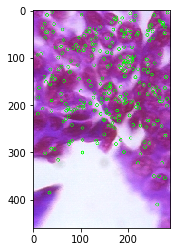

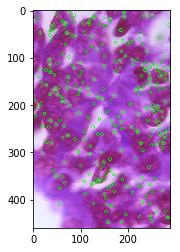

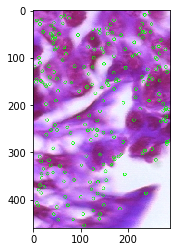

In [9]:
for i in images:
    sift = cv2.xfeatures2d.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(i, None)
    img2 = cv2.drawKeypoints(i, keypoints, None, color=(0,255,0), flags=0)
    plt.imshow(img2)
    plt.show()